# Exploratory Data Analysis

In this notebook we will carry out the Exploratory Data Analysis needed to understand the data we have available in our dataset, in order to create the most effective machine learning models possible. Our goal will be to analyse each variable's behaviour, with the aim of finding any possible outliers or missing values, as well as plotting this information for us to be easier to interpret it.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
df_raw = pd.read_csv("../data/raw/predictive_maintenance.csv")

In [3]:
df_raw.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Understanding the dataset

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Our dataset is composed by 10000 records of a certain machine's production. It includes 10 columns, each one representing the values of some variables at the moment of production, as well as two target columns, one of them being a boolean variable -whether the machine failed or not- and the other being the kind of failure that the machine experimented. There are no null records in the dataset.

We will now proceed to analyse the information that each one of the columns provides us:

### 1. UDI

In [5]:
df_raw["UDI"].head()

0    1
1    2
2    3
3    4
4    5
Name: UDI, dtype: int64

This column is the unique identifier for each record of the dataset. We will not use this column as it will not provide us any relevant information.

In [6]:
df_raw = df_raw.drop(columns=["UDI"])

### 2. Product ID & 3. Type

In [7]:
df_raw["Product ID"].head()

0    M14860
1    L47181
2    L47182
3    L47183
4    L47184
Name: Product ID, dtype: object

In [8]:
df_raw["Type"].head()

0    M
1    L
2    L
3    L
4    L
Name: Type, dtype: object

These two variables consist of a letter (L, M, H) and a serial number. These three letters represent the quality of the manufactured product, that is, L for low, M for medium and H for high. We will drop the Product ID column as it does not provide any new information compared to the Type variable.

In [9]:
df_raw = df_raw.drop(columns=["Product ID"])

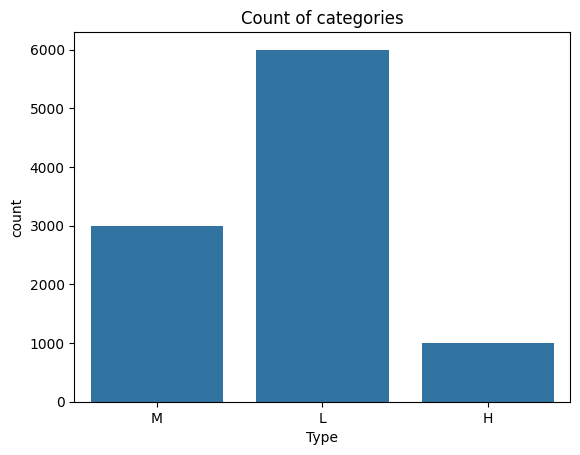

In [10]:
plt.title("Count of categories")
sns.countplot(data=df_raw, x=df_raw["Type"]);

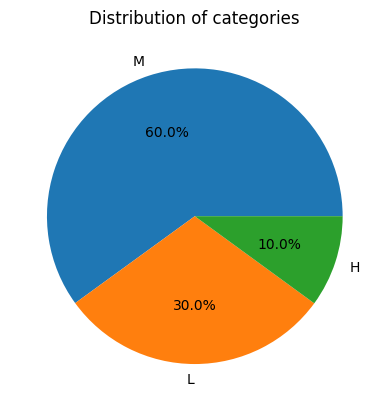

In [11]:
plt.title("Distribution of categories")
plt.pie(df_raw['Type'].value_counts(), labels=df_raw['Type'].unique(), autopct='%1.1f%%');

As we can see, the distribution of the different categories of this variable is not balanced. 60% of the records belong to medium quality products, 30% to low and 10% to high. The model will have to interpret this imbalance and try to find a relation with the target. It is not recommended to resample the independent variables of our dataset as this would apply a bias to our data.

On the other hand, this being a categorical value we need to translate those H, M and L letters into numerical values, so that the future models we create are able to interpret this variable. In order to do this, we will implement the One Hot Encoding technique.

In [12]:
df_raw = pd.get_dummies(data=df_raw, columns=["Type"], drop_first=False, dtype=np.uint8)
df_raw

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Type_H,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,0,No Failure,0,1,0
2,298.1,308.5,1498,49.4,5,0,No Failure,0,1,0
3,298.2,308.6,1433,39.5,7,0,No Failure,0,1,0
4,298.2,308.7,1408,40.0,9,0,No Failure,0,1,0
...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,No Failure,0,0,1
9996,298.9,308.4,1632,31.8,17,0,No Failure,1,0,0
9997,299.0,308.6,1645,33.4,22,0,No Failure,0,0,1
9998,299.0,308.7,1408,48.5,25,0,No Failure,1,0,0


### 4. Air temperature [K]

In [13]:
df_raw["Air temperature [K]"].head()

0    298.1
1    298.2
2    298.1
3    298.2
4    298.2
Name: Air temperature [K], dtype: float64

This column provides us information about the temperature of the air in Kelvin.

In [14]:
df_raw["Air temperature [K]"].agg(['max', 'min', 'mean', 'median', 'std'])

max       304.500000
min       295.300000
mean      300.004930
median    300.100000
std         2.000259
Name: Air temperature [K], dtype: float64

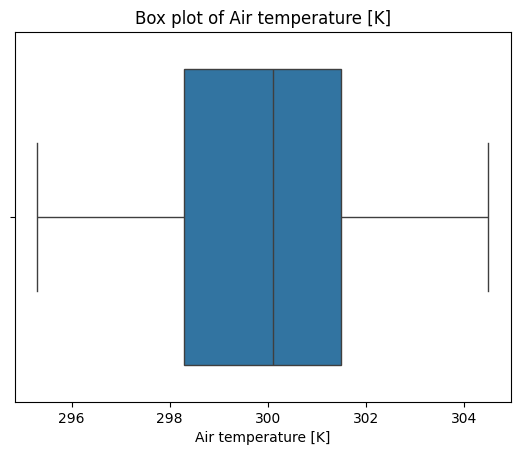

In [16]:
sns.boxplot(df_raw["Air temperature [K]"], orient="h")
plt.title("Box plot of Air temperature [K]");

As we can see in the box plot, values are distributed more or less normally, with a little negative skewness, meaning it is slightly skewed towards the top of the data. The median is located almost exactly at 300K, with a standard deviation of around 2K, as Q1 is located around 298K and Q3 around 302K. We can see there are no outliers.

### 5. Process temperature [K]

In [17]:
df_raw["Process temperature [K]"].head()

0    308.6
1    308.7
2    308.5
3    308.6
4    308.7
Name: Process temperature [K], dtype: float64

This variable includes, more or less, the value of the Air temperature variable, plus 10K.

In [18]:
df_raw["Process temperature [K]"].agg(['max', 'min', 'mean', 'median', 'std'])

max       313.800000
min       305.700000
mean      310.005560
median    310.100000
std         1.483734
Name: Process temperature [K], dtype: float64

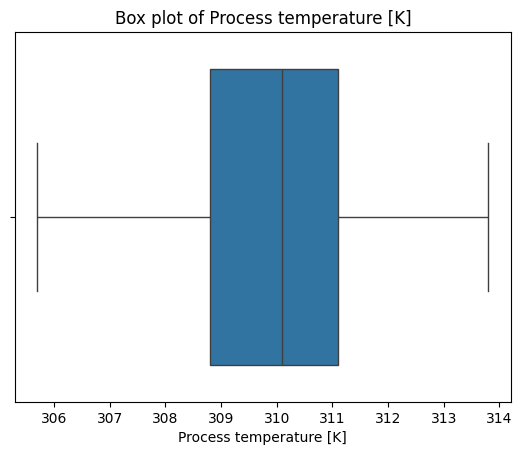

In [19]:
sns.boxplot(df_raw["Process temperature [K]"], orient="h")
plt.title("Box plot of Process temperature [K]");

As we see in the box plot, the distribution of this variable is pretty similar to the Air temperature [K] one. No outliers are perceived.

### 6. Rotational speed [rpm]

In [20]:
df_raw["Rotational speed [rpm]"].head()

0    1551
1    1408
2    1498
3    1433
4    1408
Name: Rotational speed [rpm], dtype: int64

In [21]:
df_raw["Rotational speed [rpm]"].agg(['max', 'min', 'mean', 'median', 'std'])

max       2886.000000
min       1168.000000
mean      1538.776100
median    1503.000000
std        179.284096
Name: Rotational speed [rpm], dtype: float64

This variable gives us information about the rotational speed of a part of the machine, expressed in revolutions per minute (rpm). This is calculated taking into account a power of 2860W. Some normally distributed noise is added to give the variable a more realistic approach.

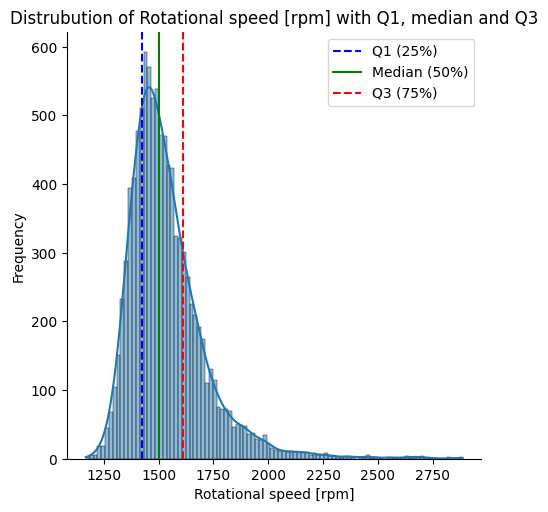

In [23]:
q1 = np.percentile(df_raw["Rotational speed [rpm]"], 25)
median = np.percentile(df_raw["Rotational speed [rpm]"], 50)
q3 = np.percentile(df_raw["Rotational speed [rpm]"], 75)

sns.displot(df_raw["Rotational speed [rpm]"], kde=True)

plt.axvline(q1, color='blue', linestyle='--', label='Q1 (25%)')
plt.axvline(median, color='green', linestyle='-', label='Median (50%)')
plt.axvline(q3, color='red', linestyle='--', label='Q3 (75%)')

plt.legend()
plt.xlabel("Rotational speed [rpm]")
plt.ylabel("Frequency")
plt.title("Distrubution of Rotational speed [rpm] with Q1, median and Q3")
plt.show()

In [24]:
q1 = np.percentile(df_raw["Rotational speed [rpm]"], 25)
q3 = np.percentile(df_raw["Rotational speed [rpm]"], 75)
iqr = q3 - q1

outliers_upper_limit = df_raw["Rotational speed [rpm]"][df_raw["Rotational speed [rpm]"]  > (q3 + 1.5 * iqr)]
print(f"Quantity of outliers: {len(outliers_upper_limit)}")

outliers_percentage = len(outliers_upper_limit) / df_raw["Rotational speed [rpm]"].count() * 100
print(f"Percentage of outliers out of the total: {outliers_percentage}%")

Quantity of outliers: 418
Percentage of outliers out of the total: 4.18%


As can be seen in the density plot, the variable is clearly distributed with a positive skewness, as the maximum value of 2886 is much further away from the median (1503) than the minimum value of 1168. We need to consider if those outliers simply add noise to our future models or whether they provide us with key information about when a machine is likely to suffer from a failure.

Taking into account that, by standard, we consider to be an outlier any point over Q3 plus 1.5 times the interquartile range, 4.18% of values lay over that limit. Does this present a problem for our future models? Theory tells us that, if those outliers represent realistic behaviours we should include them in our models, since they may have a relevant meaning when trying to understand why the machine failed. However, if those outliers are errors or measurement mistakes, we should eliminate them as they could interfere in the bias and reduce the precision of the models. Moreover, some models are more sensitive to outliers than others, so we should take this into account when programming certain models.

In conclusion, the best choice may be to train some models using the whole dataset, including outliers, and compare the results with the ones obtained training models excluding outlier values. We will find out the right answer as we try different options.

### 7. Torque [Nm]

In [25]:
df_raw["Torque [Nm]"].head()

0    42.8
1    46.3
2    49.4
3    39.5
4    40.0
Name: Torque [Nm], dtype: float64

In [26]:
df_raw["Torque [Nm]"].agg(['max', 'min', 'mean', 'median', 'std'])

max       76.600000
min        3.800000
mean      39.986910
median    40.100000
std        9.968934
Name: Torque [Nm], dtype: float64

This variable indicates the metrics for the rotation power of the machine. It is represented in Newton-meters (Nm). 

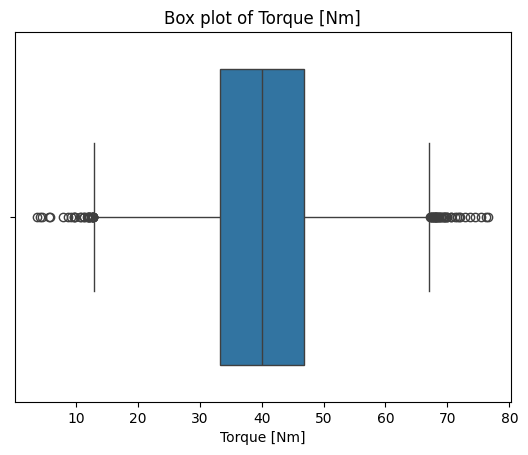

In [28]:
sns.boxplot(df_raw["Torque [Nm]"], orient="h")
plt.title("Box plot of Torque [Nm]");

The box plot indicates that the variable follows a pretty normal distribution, with a median of 40Nm and a sigma value of 10Nm. We will create a distribution plot to see how the outliers present in this variable behave. We will plot a curve for the normal distribution in order to graphically see if the variable follows a normal distribution or not.

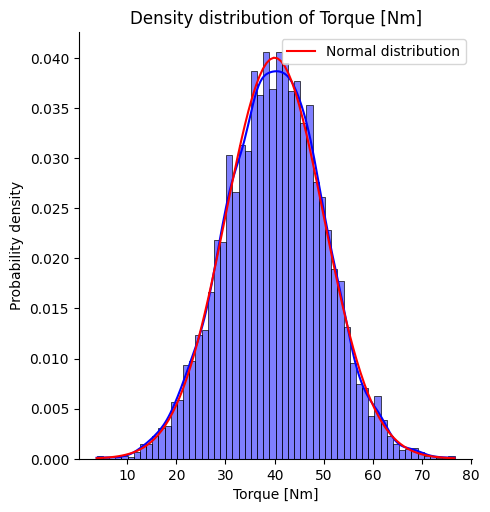

In [31]:
mean = df_raw["Torque [Nm]"].mean()
std_dev = df_raw["Torque [Nm]"].std()

sns.displot(df_raw["Torque [Nm]"], kde=True, color="blue", stat="density")

# Here we manually calculate the mean and standard deviation in order to plot the normal distribution curve
x = np.linspace(df_raw["Torque [Nm]"].min(), df_raw["Torque [Nm]"].max(), 100)
normal_dist = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

plt.plot(x, normal_dist, color="red", label="Normal distribution")
plt.legend()
plt.xlabel("Torque [Nm]")
plt.ylabel("Probability density")
plt.title("Density distribution of Torque [Nm]")
plt.show()

As we can see, the variable follows almost perfectly a normal distribution

### 8. Tool wear [min]

In [32]:
df_raw["Torque [Nm]"].head()

0    42.8
1    46.3
2    49.4
3    39.5
4    40.0
Name: Torque [Nm], dtype: float64

In [33]:
df_raw["Torque [Nm]"].agg(['max', 'min', 'mean', 'median', 'std'])

max       76.600000
min        3.800000
mean      39.986910
median    40.100000
std        9.968934
Name: Torque [Nm], dtype: float64

This variable represents the wear time that the tool suffers, represented in minutes. It is worth noting that high quality products add 5 minutes of tool wear, medium quality ones add 3 minutes and low quality ones add 2 minutes. This indicates that, in the case of high quality products, the tool needs a higher precision in the process, so that it suffers a higher time of wear. We will plot this variable in terms of the quality of the product in order to see this differenciation.

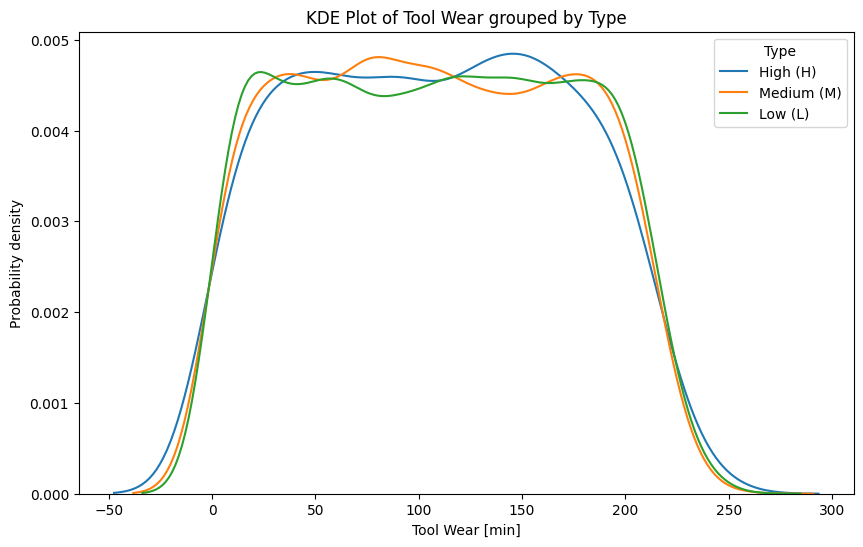

In [34]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_raw[df_raw['Type_H'] == 1], x="Tool wear [min]", label="High (H)")
sns.kdeplot(data=df_raw[df_raw['Type_M'] == 1], x="Tool wear [min]", label="Medium (M)")
sns.kdeplot(data=df_raw[df_raw['Type_L'] == 1], x="Tool wear [min]", label="Low (L)")

plt.title('KDE Plot of Tool Wear grouped by Type')
plt.xlabel('Tool Wear [min]')
plt.ylabel('Probability density')
plt.legend(title='Type')
plt.show()

All three curves appear to be similar, which suggests that tool wear in all product types is evenly distributed. However, we can see slight differences among the density curves. The line in green, representing high quality products, appears to be slightly displaced to the right, compared to the others. This indicates that high quality products may generate a higher tool wear, which is totally reasonable. Differences between medium and low quality products are not as clear, in comparison to high quality ones. All in all, even though differences among the three qualities are visible, I believe it is right to say that this is not a factor that determines overall tool wear clearly.

### Target (binary)

This column will be the target or dependent variable that indicates whether the machine failed or not.

In [35]:
df_raw["Target"].head()

0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64

In [36]:
df_raw["Target"].unique()

array([0, 1])

In [37]:
failure_count = df_raw["Target"][df_raw["Target"] == 1].count()
not_failure_count = df_raw["Target"][df_raw["Target"] == 0].count()
failure_percentage = failure_count / df_raw["Target"].count() * 100

print(f"Count of failures: {failure_count}")
print(f"Count of not failures: {not_failure_count}")
print(f"Failure percentage: {failure_percentage} %")

Count of failures: 339
Count of not failures: 9661
Failure percentage: 3.39 %


As we see, target is notoriously imbalanced. There are only 3.39% of records showing a failure of the machine. Facing this situation, some balancing technique will be needed in order to adjust this imbalance. An imbalanced dependent variable may be considered one of the most challenging aspects of reliable machine learning models. However, this is usually the case for many different industries, as the records of failing processes are more uncommon than successful ones. There are several techniques that machine learning specialists can apply with the aim of tackling this issue.

In the case of binary classification tasks, we consider to be a "class imbalance" any target variable with a 80-20 proportion or higher. With regard to our dataset, the proportion is around 97-3 so the challenge here is even greater.

### Failure Type

This column will act as a categoric target, indicating what kind of failure the machine experimented.

In [38]:
df_raw["Failure Type"].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

As can be seen, there are 5 different failure types. Obviously, this column also includes "No Failure" which is present in the records that there was no failure at all (Target = 0). Let's analyse how this five types are distributed.

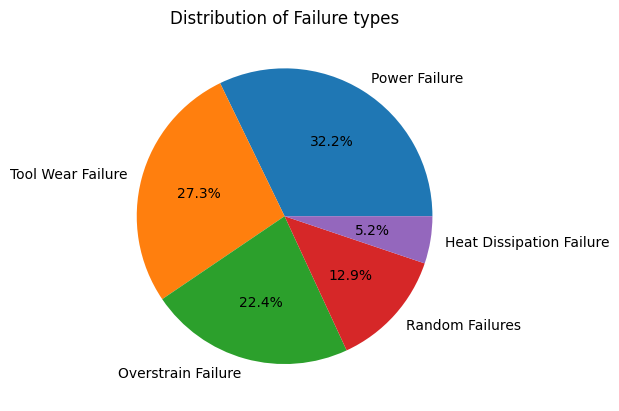

In [40]:
plt.pie(df_raw['Failure Type'][df_raw["Failure Type"] != "No Failure"].value_counts(), labels=df_raw['Failure Type'][df_raw["Failure Type"] != "No Failure"].unique(), autopct='%1.1f%%')
plt.title("Distribution of Failure types");

Seeing this distribution and taking into account that the binary target has a 97-3 proportion imbalance, it is clear that our dataset contains too few records for every class of our categorical target. We consider that the dataset does not provide enough information for every class and that our models will not be able to distinguish between failure types properly. We could consider applying some kind of sampling technique to this target as well, however we believe that the amount of artificial information added would be too significant, to the extent of having much more artificial values than original ones, thus losing all sight of our real data. In conclusion, we will proceed to programme models in order to find out whether the machine failed or not, and cast aside the idea of trying to predict the reason of failures.

**Before taking any step further**, we will separate our dataset in two parts: one including the binary target and the other including the categorical target. As mention, we will proceed to work only with the binary target.

In [36]:
# This lines will be kept commented during development to avoid file overwriting

# df_raw.drop(columns=["Failure Type"]).to_csv("../data/raw/raw_binary.csv", index=False)
# df_raw.drop(columns=["Target"]).to_csv("../data/raw/raw_categorical.csv", index=False)

In [42]:
df_raw_bin = pd.read_csv("../data/raw/raw_binary.csv")

## Multivariative analysis

Multivariative analysis takes us one step further and allows us to do a more complete analysis of our data by looking at all possible independent variables and their relationships to one another. We will start by plotting all variables together.

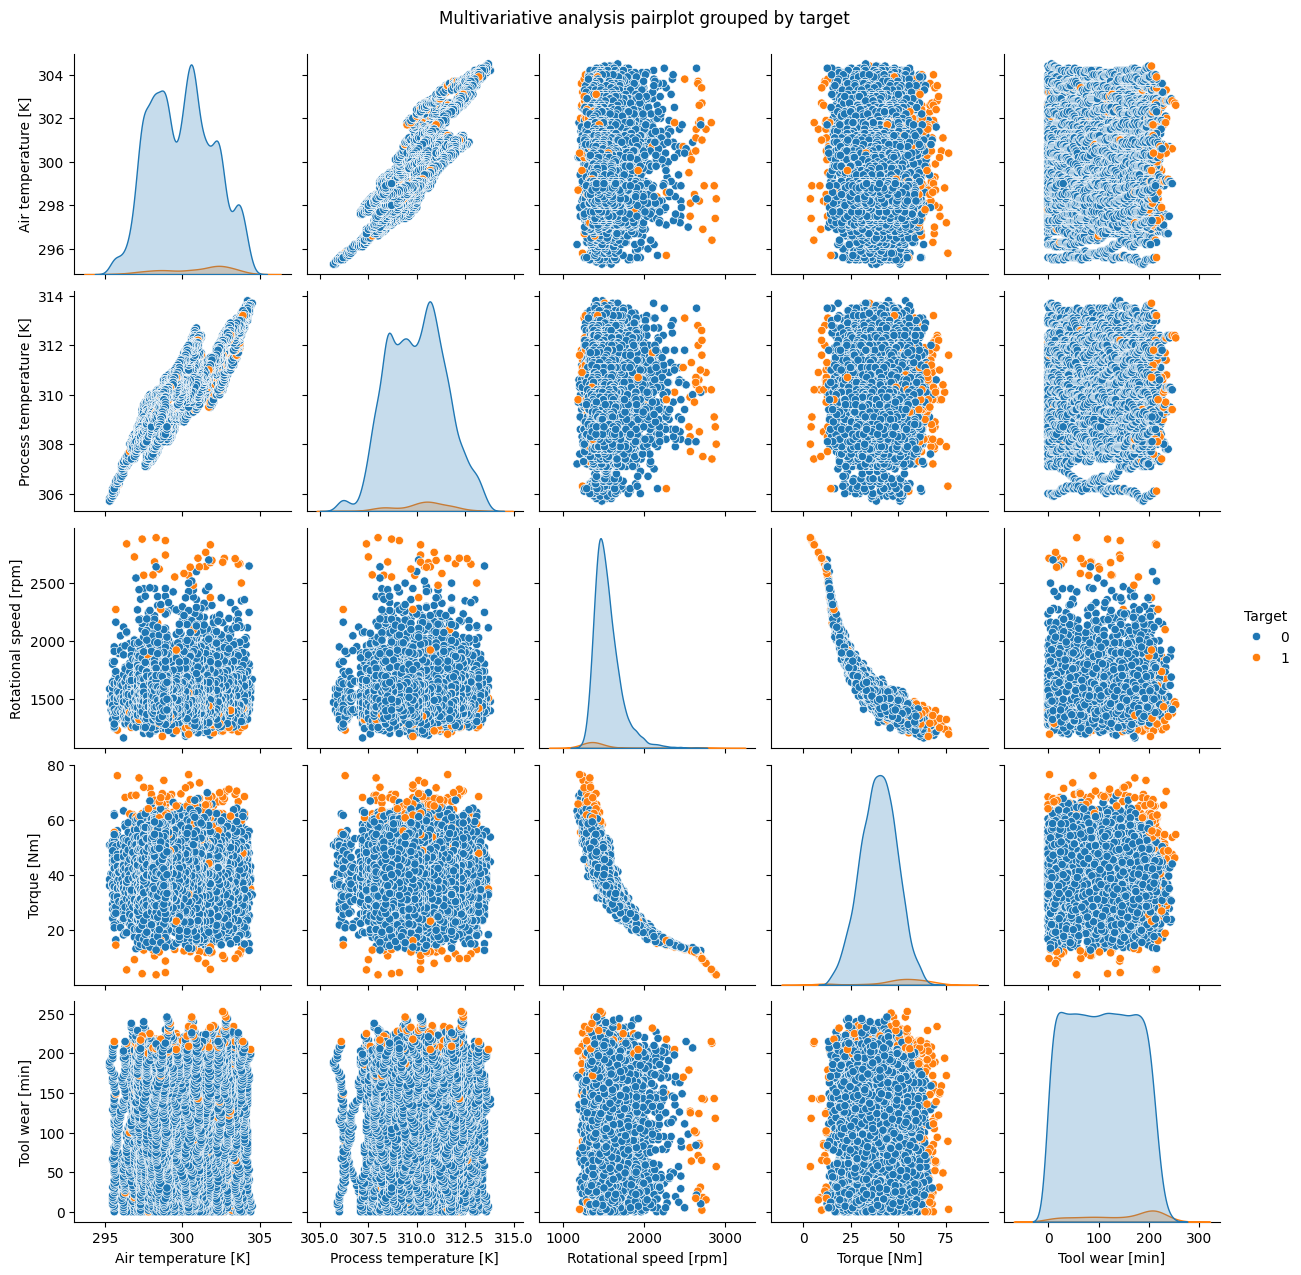

In [50]:
sns.pairplot(data=df_raw_bin.drop(columns=["Type_L", "Type_M", "Type_H"]), hue="Target")
plt.suptitle("Multivariative analysis pairplot grouped by target", y=1.02);

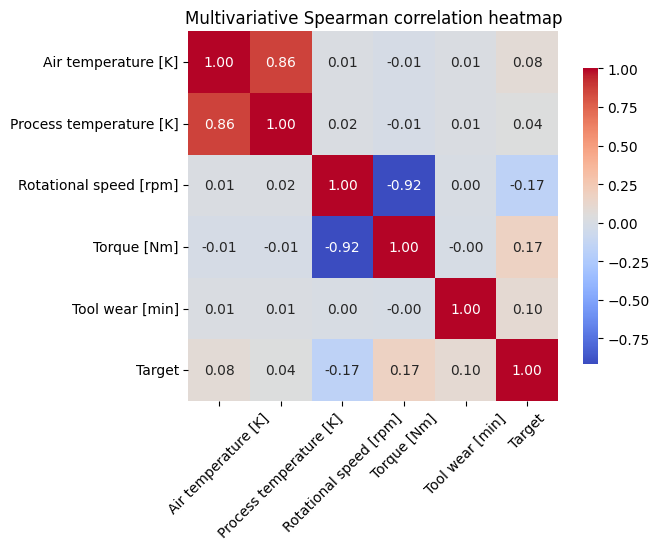

In [55]:
sns.heatmap(df_raw_bin.drop(columns=["Type_L", "Type_M", "Type_H"]).corr(method="spearman"), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.xticks(rotation=45)
plt.title("Multivariative Spearman correlation heatmap");

Conclusions extracted from multivariative analysis:
1. There are two pairs of variables that have almost a perfect correlation. That is the case for **air temperature & process temperature**, and **torque & rotational speed**. In the first case, this correlation could be deduced because we know that process temperature is simply air temperature plus 10 Kelvin. As for torque and rotational speed, this two magnitudes are inversely related, as Power is the product of Torque and angular speed. This means that we will have to eliminate from our dataframe one variable for every pair, in order to avoid multicollinearity problems. In this case we will eliminate air temperature, as process temperature is more relevant to our target. When it comes to torque and rotational speed we will need to check which of the two is more related to our target. 

It is important not to use Pearson, Spearman or Kendall kind of correlation indexes, due to the fact that we are calculating the correlation with a dicotomic target. There are other metrics more suitable for this kind of issues, such as ROC_AUC, which we will calculate now.

ROC-AUC Score: 0.77


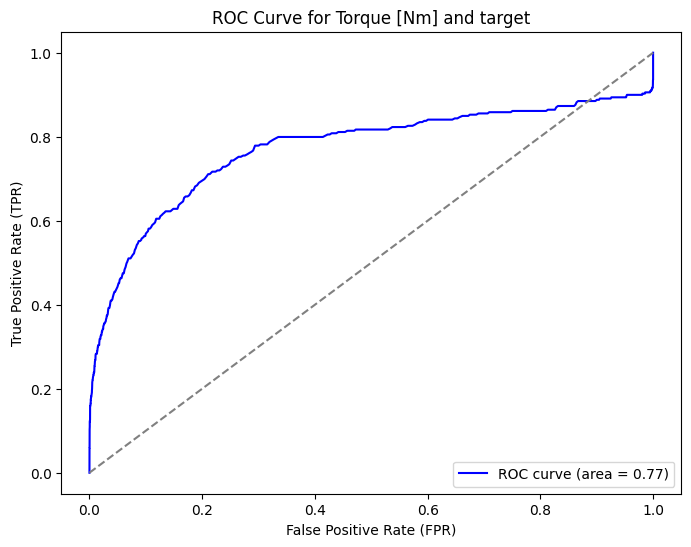

In [63]:
X_var = df_raw_bin["Torque [Nm]"]
y_target = df_raw_bin["Target"]

roc_auc = roc_auc_score(y_target, X_var)
print(f"ROC-AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_target, X_var)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Torque [Nm] and target')
plt.legend(loc="lower right")
plt.show()

ROC-AUC Score: 0.23


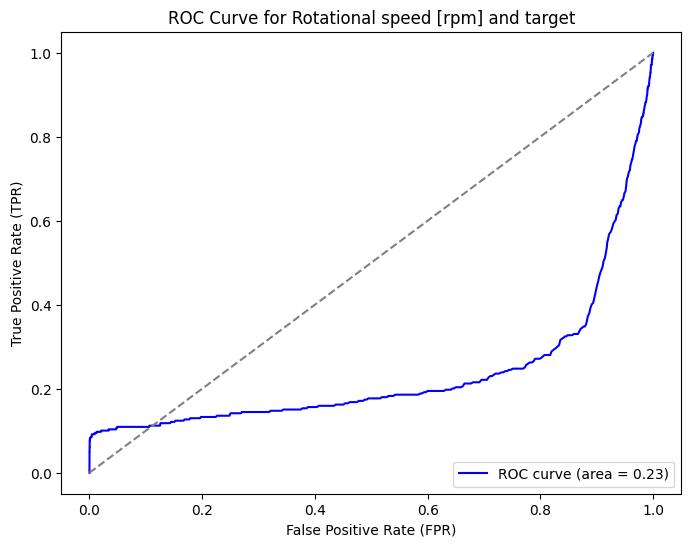

In [64]:
X_var = df_raw_bin["Rotational speed [rpm]"]
y_target = df_raw_bin["Target"]

roc_auc = roc_auc_score(y_target, X_var)
print(f"ROC-AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_target, X_var)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Rotational speed [rpm] and target')
plt.legend(loc="lower right")
plt.show()

As we see, ROC scores for Torque and Rotational speed are 0.77 and 0.23, respectively. On the other hand, as far as the ROC curves are concerned, we clearly see that the curve for Torque is above the 45º line, which represents a totally random classification, meaning this variable discriminates pretty well when classifying a record between the values of the dicotomic target. When it comes to Rotational speed, the curve is almost entirely below the reference diagonal line, which indicates that it is not a useful variable when it comes to a binary target.

To sum up, we will eliminate Air temperature and Rotational speed variables from our dataset.

In [65]:
df_raw_bin = df_raw_bin.drop(columns=["Air temperature [K]", "Rotational speed [rpm]"])

2. The second conclusion that we can extract by inspecting the visualisations of the multivariative analysis is that variables do not follow a visible distribution, not in relation to other variables, nor with the target itself. Moreover, regarding the correlation heatmap (calculated using Spearman correlation index) we see that variables do not show almost any correlation with the target. This will likely be an issue when we start programming our models.

## Sampling techniques

So far, we have concluded that we need to apply sampling techniques in our binary target. There are several techniques to fix the imbalance in our dataset. Let's explore what each of those can offer us and decide which suits our dataset best.

### Undersampling:
It involves reducing the number of samples in the majority class in order to balance it with the minority class. To put it simple, usually some records are randomly eliminated until a desired ratio of mayority-minority classes is reached. This technique can save storage and computation resources and lead to positive results in most cases. Nevertheless, in cases that datasets may be short, we risk eliminating representative records and losing relevant information.

### Oversampling:
It involves artificially increasing the number of records in the minority class. The most common method is random oversampling, which in essence just duplicates random data points in order to give those a bigger preponderance. On the other hand, some more complex techniques that may provide better results include SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic oversampling).

The decision of which sampling technique to use is not always clear and it usually involves a bit of trial and error. In our case, taking into account that our dataset is not specially long (10K records) we believe that eliminating data by undersampling may be a mistake. Our choice will be to use SMOTE as it may provide more positive results and it is a widely accepted solution. We will apply a 80-20 proportion in order to avoid artificially creating too many new records, given our current proportion is 97-3

In [66]:
X = df_raw_bin.drop(columns=["Target"])
y = df_raw_bin["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

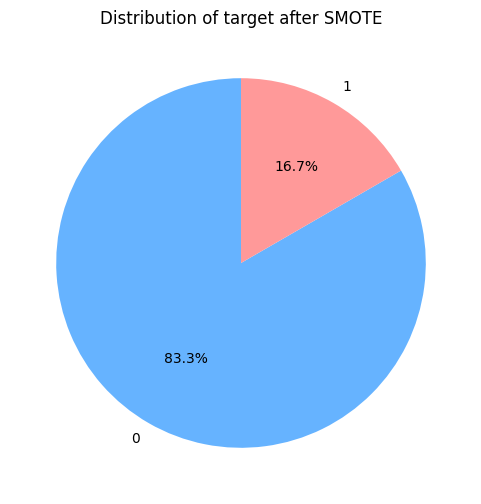

In [67]:
value_counts = y_train_resampled.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of target after SMOTE')
plt.show()

By applying SMOTE we have achieved a distribution of 83-17. This distribution is an acceptable value to train a model, while we are not adding too many artificial values to the extent of overflowing the original dataset with them. Now we will concatenate all our registers in order to have a full resampled dataframe.

In [68]:
df_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_full = pd.concat([df_train_resampled, df_test], axis=0).reset_index(drop=True)

In [69]:
df_full

,Process temperature [K],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target
0,309.1,31.1,195,0,1,0,0
1,308.4,53.8,137,0,1,0,0
2,307.8,31.1,194,0,1,0,0
3,310.8,33.0,7,0,0,1,0
4,310.5,33.9,208,0,1,0,0
...,...,...,...,...,...,...,...
11261,310.0,44.2,189,0,1,0,0
11262,310.6,52.7,2,0,1,0,0
11263,311.7,56.5,7,0,1,0,0
11264,307.5,9.3,18,0,1,0,1


## Value standardisation

The last step of this data cleaning and preparation process is to standardise the values. In our case, we have three variables with clearly different values, which can be noted by the fact that one is expressed in Kelvin, another in Newton-metres and the other in Minutes. Since this mix of magnitudes could apply a bias to our data we should try to standardise these variables. Some models, specially the ones based on Euclidean distance, suffer from not normalised data, so standardising our data is a good practice, even if we end up not using this kind of models.

Since our variables follow a, more or less, normal distribution, our choice will be to use Z-Score standardisation. We will only apply the scaling to the following variables: Process temperature, Torque and Tool wear. As our dummy variables of the Type column are binary values, there is no need to apply any scaling to these.

On the other hand, it is important to remember that we must train our scaler only with the training set and never with our whole dataset, since that would cause an information leak. Once the scaling object is fit with the training set, then we can transform all our data with that scaler.

In [70]:
X = df_full.drop(columns=["Type_H", "Type_L", "Type_M", "Target"])
y = df_full["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
std_scaler.fit(X_train, y_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

Now we will concatenate all our data again in order to have our dataset clean and ready to train models with it.

In [71]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

dummies_train = df_full.loc[X_train.index, ["Type_H", "Type_L", "Type_M"]]
dummies_test = df_full.loc[X_test.index, ["Type_H", "Type_L", "Type_M"]]
target_train = y_train
target_test = y_test

X_train_full = pd.concat([X_train_scaled_df, dummies_train, target_train], axis=1)
X_test_full = pd.concat([X_test_scaled_df, dummies_test, target_test], axis=1)

df_full_scaled = pd.concat([X_train_full, X_test_full])

In [72]:
df_full_scaled

,Process temperature [K],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target
8475,0.000944,1.307442,1.397594,0,1,0,1
7658,-1.967206,-0.290731,-1.623324,0,1,0,0
10212,-0.929433,-0.078252,0.031350,0,1,0,0
11200,1.492037,1.550753,-1.668866,0,0,1,0
8900,0.926976,1.622320,1.306511,0,1,0,1
...,...,...,...,...,...,...,...
3991,-1.275357,-0.281878,1.078804,0,0,1,0
8888,0.673988,-2.679677,-1.532241,0,0,1,1
2360,0.315895,-1.547898,0.107252,1,0,0,0
10013,0.523449,-0.609449,0.471584,0,0,1,0


We can say that our data analysis and dataset preprocessing now is over. We have delved into each of the original variables, studied how their values are distributed, decided whether they were relevant to our target, examined the relations among them and the target, carried out a resampling process and finally scaled our variables, resulting in our clean and ready to be used dataframe. Now it is time to start programming models and testing them in order to see if we can predict when our machine is likely to fail with the information available. We will now export this dataframe to a CSV file and store it in a new folder which will include our processed data.

In [ ]:
# This lines will be kept commented during development to avoid file overwriting
# df_full_scaled.to_csv("../data/clean/clean_binary.csv", index=False)